# Projet de Recherche : Implémentation de la NMF en Python 

**Objectif :** Ce notebook a pour but d'implémenter l'algorithme de Factorisation en Matrices Non-négatives (NMF)  en utilisant uniquement les bibliothèques Python standard.

**Étapes :**
1.  Développement de fonctions utilitaires pour les opérations sur les matrices (listes de listes).
2.  Implémentation de l'algorithme NMF principal.
3.  Préparation d'un jeu de données expérimental.
4.  Exécution et chronométrage de notre implémentation.
5.  Comparaison avec l'implémentation de référence de Scikit-learn.
6.  Visualisation des résultats pour le rapport final.

In [8]:
# Bibliothèques standard pour l'algorithme
import random
import math
import time

# Bibliothèques pour la comparaison, la gestion des données et la visualisation
# NOTE : NumPy ne sera utilisé QUE pour manipuler les données de sklearn et pour faciliter l'affichage.
# Les calculs de notre algorithme NMF n'utiliseront PAS NumPy.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import NMF

In [9]:
# --- Fonctions de base pour manipuler les matrices (listes de listes) ---

def transpose(matrix):
    """Calcule la transposée d'une matrice."""
    n_rows, n_cols = len(matrix), len(matrix[0])
    return [[matrix[i][j] for i in range(n_rows)] for j in range(n_cols)]

def multiply_matrices(A, B):
    """Effectue la multiplication de deux matrices A et B."""
    n_rows_A, n_cols_A = len(A), len(A[0])
    n_rows_B, n_cols_B = len(B), len(B[0])
    
    if n_cols_A != n_rows_B:
        raise ValueError("Dimensions incompatibles pour la multiplication.")
        
    result = [[0] * n_cols_B for _ in range(n_rows_A)]
    for i in range(n_rows_A):
        for j in range(n_cols_B):
            for k in range(n_cols_A):
                result[i][j] += A[i][k] * B[k][j]
    return result

def elementwise_op(A, B, op):
    """Applique une opération (ex: multiplication) terme à terme."""
    n_rows, n_cols = len(A), len(A[0])
    return [[op(A[i][j], B[i][j]) for j in range(n_cols)] for i in range(n_rows)]

def matrix_frobenius_norm(V, V_approx):
    """Calcule la norme de Frobenius de la différence entre V et V_approx."""
    error = 0
    for i in range(len(V)):
        for j in range(len(V[0])):
            error += (V[i][j] - V_approx[i][j]) ** 2
    return math.sqrt(error)

print("Fonctions utilitaires pour les matrices définies.")

Fonctions utilitaires pour les matrices définies.


In [10]:
def nmf_pure_python(V, k, max_iter=200):
    """Implémentation de la NMF en utilisant les fonctions utilitaires."""
    n, m = len(V), len(V[0])
    epsilon = 1e-9  # Pour éviter les divisions par zéro
    
    # 1. Initialisation
    W = [[random.random() for _ in range(k)] for _ in range(n)]
    H = [[random.random() for _ in range(m)] for _ in range(k)]
    
    reconstruction_errors = []

    for i in range(max_iter):
        # 2a. Mise à jour de H
        Wt = transpose(W)
        numerator_H = multiply_matrices(Wt, V)
        WtW = multiply_matrices(Wt, W)
        denominator_H_base = multiply_matrices(WtW, H)
        denominator_H = [[x + epsilon for x in row] for row in denominator_H_base]
        
        H_update_ratio = elementwise_op(numerator_H, denominator_H, lambda a, b: a / b)
        H = elementwise_op(H, H_update_ratio, lambda a, b: a * b)
                           
        # 2b. Mise à jour de W
        Ht = transpose(H)
        numerator_W = multiply_matrices(V, Ht)
        HHt = multiply_matrices(H, Ht)
        denominator_W_base = multiply_matrices(W, HHt)
        denominator_W = [[x + epsilon for x in row] for row in denominator_W_base]
        
        W_update_ratio = elementwise_op(numerator_W, denominator_W, lambda a, b: a / b)
        W = elementwise_op(W, W_update_ratio, lambda a, b: a * b)
        
        # Calcul de l'erreur de reconstruction pour le graphique de convergence
        V_approx = multiply_matrices(W, H)
        error = matrix_frobenius_norm(V, V_approx)
        reconstruction_errors.append(error)

    return W, H, reconstruction_errors

print("Algorithme NMF en Python pur défini.")

Algorithme NMF en Python pur défini.


### Étape 3 : Préparation de l'Expérience

Nous allons utiliser le jeu de données `digits` de Scikit-learn. Pour rendre les "bases" plus interprétables, nous allons nous concentrer sur un seul chiffre, le '0'.

Nous utilisons  un **très petit sous-ensemble** de données (50 images) pour que les calculs se terminent en un temps raisonnable.

In [11]:
# Chargement des données
digits = load_digits()
data_zeros = digits.data[digits.target == 0]

# --- PARAMETRES DE L'EXPERIENCE ---
N_SAMPLES = 50      # Nombre d'images à utiliser
RANK_K = 5           # Nombre de composantes à extraire (k)
MAX_ITERATIONS = 500 # Nombre d'itérations

# Préparation du sous-ensemble de données
# Note : la NMF travaille avec V (n_features x n_samples), donc on transpose
data_subset = data_zeros[:N_SAMPLES].T 

# Conversion en liste de listes pour notre implémentation
V_list = data_subset.tolist()

print(f"Jeu de données préparé : {len(V_list)} features, {len(V_list[0])} samples.")
print(f"Rang de factorisation k = {RANK_K}")

Jeu de données préparé : 64 features, 50 samples.
Rang de factorisation k = 5


In [15]:
print("Lancement de l'implémentation NMF en Python pur... (cela peut prendre du temps)")

start_time = time.time()
W_scratch, H_scratch, errors_scratch = nmf_pure_python(V_list, k=RANK_K, max_iter=MAX_ITERATIONS)
end_time = time.time()

time_scratch = end_time - start_time
print(f"Temps d'exécution (Python pur) : {time_scratch:.2f} secondes")

Lancement de l'implémentation NMF en Python pur... (cela peut prendre du temps)
Temps d'exécution (Python pur) : 13.32 secondes


In [16]:
print("Lancement de l'implémentation de Scikit-learn...")

# On utilise les données NumPy originales (data_subset) pour sklearn
model = NMF(n_components=RANK_K, init='random', solver='mu', max_iter=MAX_ITERATIONS, random_state=42)

start_time = time.time()
# Scikit-learn attend des données (n_samples x n_features), donc on re-transpose
W_sklearn = model.fit_transform(data_subset.T)
H_sklearn = model.components_
end_time = time.time()

time_sklearn = end_time - start_time
print(f"Temps d'exécution (Scikit-learn) : {time_sklearn:.4f} secondes")

Lancement de l'implémentation de Scikit-learn...
Temps d'exécution (Scikit-learn) : 0.0568 secondes


In [14]:
# --- CALCUL DES ERREURS FINALES POUR LE TABLEAU ---

# Pour notre implémentation, l'erreur est la dernière valeur de la liste que nous avons enregistrée.
final_error_scratch = errors_scratch[-1]

# Pour Scikit-learn, le modèle calcule l'erreur pour nous.
# Note : Il est déjà au carré, donc on prend la racine carrée pour la norme de Frobenius.
final_error_sklearn = model.reconstruction_err_

print("--- RÉSULTATS FINAUX POUR LE RAPPORT ---")
print(f"Temps d'exécution (Python Pur): {time_scratch:.2f} secondes")
print(f"Erreur de reconstruction (Python Pur): {final_error_scratch:.1f}")
print("-" * 20)
print(f"Temps d'exécution (Scikit-learn): {time_sklearn:.4f} secondes")
print(f"Erreur de reconstruction (Scikit-learn): {final_error_sklearn:.1f}")

--- RÉSULTATS FINAUX POUR LE RAPPORT ---
Temps d'exécution (Python Pur): 12.63 secondes
Erreur de reconstruction (Python Pur): 78.6
--------------------
Temps d'exécution (Scikit-learn): 0.0566 secondes
Erreur de reconstruction (Scikit-learn): 78.1


### Étape 6 : Analyse des Résultats et Visualisation

Maintenant, nous allons générer les graphiques nécessaires pour notre rapport LaTeX.
1.  **Graphique de convergence** : Montre que l'erreur de notre implémentation diminue bien à chaque itération.
2.  **Visualisation des bases** : Compare les "caractéristiques" (colonnes de W) extraites par notre méthode et par Scikit-learn.

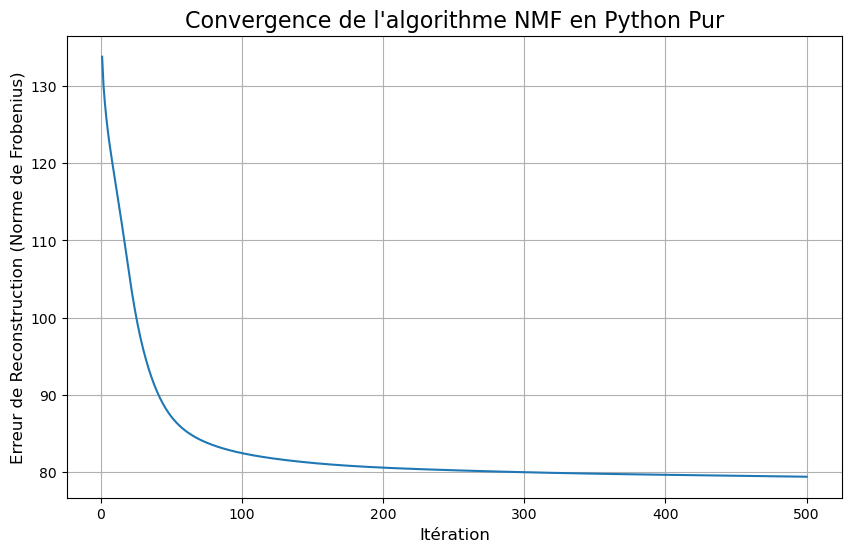

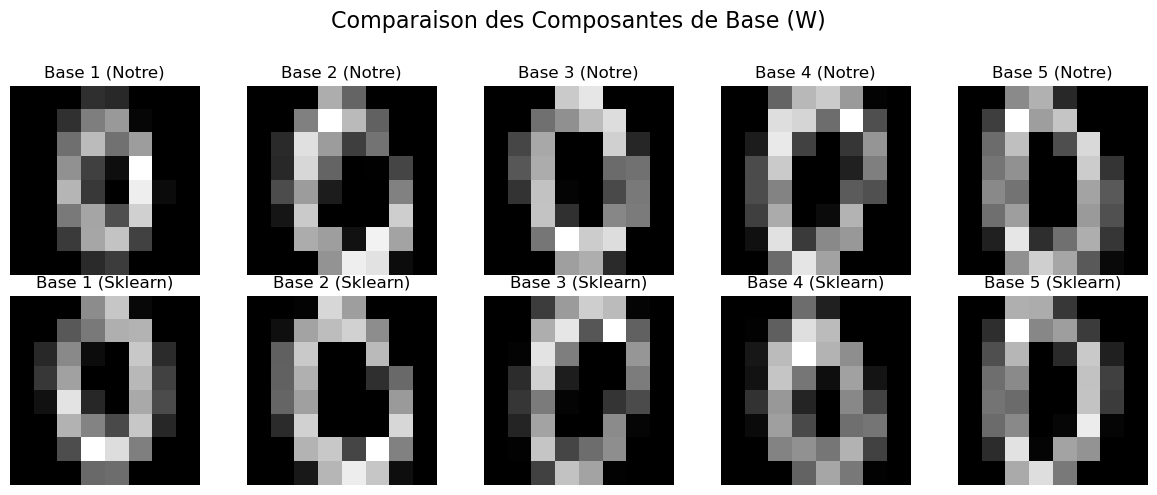

In [20]:
# 1. Graphique de la convergence de notre algorithme
plt.figure(figsize=(10, 6))
plt.plot(range(1, MAX_ITERATIONS + 1), errors_scratch)
plt.title("Convergence de l'algorithme NMF en Python Pur", fontsize=16)
plt.xlabel("Itération", fontsize=12)
plt.ylabel("Erreur de Reconstruction (Norme de Frobenius)", fontsize=12)
plt.grid(True)
plt.savefig("convergence_plot.pdf")
plt.show()

# 2. Visualisation des composantes de base (W)
# Pour afficher, nous devons convertir notre liste de listes W_scratch en array NumPy
W_scratch_np = np.array(W_scratch)

fig, axes = plt.subplots(2, RANK_K, figsize=(12, 5))
fig.suptitle('Comparaison des Composantes de Base (W)', fontsize=16)

for i in range(RANK_K):
    # Notre implémentation (W est n_features x k, donc on prend la i-ème colonne)
    ax = axes[0, i]
    ax.imshow(W_scratch_np[:, i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Base {i+1} (Notre)")
    ax.axis('off')
    
    # Scikit-learn (Les bases sont dans model.components_, qui est k x n_features)
    ax = axes[1, i]
    # On prend la i-ème LIGNE de components_, qui est la i-ème base de 64 pixels.
    base_sklearn = model.components_[i]
    ax.imshow(base_sklearn.reshape(8, 8), cmap='gray')
    ax.set_title(f"Base {i+1} (Sklearn)")
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("bases_nmf.pdf")
plt.show()